In [1]:
using Plots
include("polyfit_function.jl")
include("Lagrange_interpolation.jl")
include("LReg.jl")

LReg (generic function with 1 method)

In [3]:
function Ref(f, a, b, u0, N)
    dt=(b-a)/N
    t=(0:N)*dt
    m=2
    DT=m*dt
    U=zeros(1, N+1, 2)
    U[1, 1, 1]=u0
    U[1, 1, 2]=u0
    
    for i=1:m:N

        U[1, i, 1]=U[1, i, 2]
        for j=i:i+1
            U[1, j+1, 1]= U[1, j, 1]+dt*f(t[j], U[1, j, 1])
        end
           
        U[1, i+2, 2]= U[1, i, 2]+ DT*(f(t[i], U[1, i, 2])-f(t[i], U[1, i, 1])) + LReg(t[i:i+2], f(t[i:i+2], U[1, i:i+2, 1]), t[i], t[i+2])
    end
        
    return  U, t
end

Ref (generic function with 1 method)

In [ ]:
# Convergence test
using LinearAlgebra

u0 = 1.0
lambda= 1
a=0
b=1.0
K = 5
err = zeros(K, 1)
ns=zeros(K, 1)
m=2
f(t, y) = lambda * y

for k in 1:K
    
    N = 10*k
    
    ns[k]=N
    U, t= Ref(f, a, b, u0, N)
    exact= u0*exp.(lambda .* t)
    err[k] = norm(exact[1:m:end] .- U[1, 1:m:end, 2], Inf)
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err[:]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(ns, err[:], xaxis=:log, yaxis=:log, label="Reference Solution")
display(plot!(legend=:topright))

In [5]:
function grid2c(f, a, b, u0, N, K)
    dt=(b-a)/N
    t=(0:N)*dt
    m=2
    J= N÷m
    DT=m*dt
    Tval=(0:J)*DT
    u=zeros(1, N+1, K+1)
    u[1, 1, 1]=u0
    ps=3:m:N
    u[1, ps, 1] = rand(length(ps))


    # 2 level iteration
    fk=zeros(m+1)
    for k=1:K
        u[1, 1, k+1]=u0
        for i=1:m:N
            
            # Sequential solution on each time slice
            fk[1]=u[1, i, k]
            for j=1:m
                fk[j+1]=fk[j]+dt*f(t[i+j-1], fk[j])
            end
            
            # Updated solution on the coarse nodes
            u[1, i+2, k+1]= u[1, i, k+1]+ DT*(f(t[i], u[1, i, k+1])-f(t[i], fk[1])) + LReg(t[i:i+2], f(t[i:i+2], fk[1:3]), t[i], t[i+2])
        end
    end
        
    return u, t
end

grid2c (generic function with 1 method)

In [ ]:
# Convergence test
using LinearAlgebra

u0 = 1.0
lambda= 1
a=0
b=1.0
K = 6
err = zeros(K, 1)
ns=zeros(K, 1)
m=2
f(t, y) = lambda * y

for k in 1:K
    
    N = 10*k
    
    ns[k]=N
    u, t= grid2c(f, a, b, u0, N, K)
    exact= u0*exp.(lambda .* t)
    err[k] = norm(exact[1:m:end] .- u[1, 1:m:end, itr], Inf)
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err[:]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(ns, err[:], xaxis=:log, yaxis=:log, label="2 Level DC")
display(plot!(legend=:topright))

In [ ]:
using LinearAlgebra, Plots

u0 = 1.0
a = 0
b = 1.0
f(t, u) = u
N = 20
K = 7 # Number of Iterations
m = 2
err=zeros(K+1)
u, t= grid2c(f, a, b, u0, N, K) # Approximate Solution
U, t = Ref(f, a, b, u0, N) # Reference Solution
for k=1:K+1
    err[k]= norm(U[1, 1:m:end, 2] .- u[1, 1:m:end, k], Inf)
end
plot(0:K, err, yaxis=:log, xlabel="Number of Iterations", ylabel="Error")

In [ ]:
# Finite Step Convergenec

using LinearAlgebra, Plots

u0 = 1.0
a = 0
b = 1.0
f(t, u) = -u .+ sin.(10*t)
N = 20
K = 5 # Number of Iterations
m = 2

u, t = grid2c(f, a, b, u0, N, K) # Approximate Solution
U, t = Ref(f, a, b, u0, N) # Reference Solution

tval = t[1:m:end] # Coarse time points
err = norm.(U[1, 1:m:end, 2] .- u[1, 1:m:end, K], Inf) .+ 10^(-15)

plot(tval, err, xlabel=" Time", yaxis=:log, ylabel="Error", title="Error vs Time", xticks=(tval, string.(tval)))

In [ ]:
using LinearAlgebra, Plots

u0 = 1.0
a = 0
b = 1/2
f(t, u) =  u .^2

K = 5  # Number of Iterations
m = 2
Nk= 10
ns=zeros(Nk)
error=zeros(Nk, K)
for k=1:K
    for n=1:Nk
        N=10*n
        ns[n]=N
        u, t = grid2c(f, a, b, u0, N, k)
        U, t = Ref(f, a, b, u0, N)
        error[n, k]= norm(U[1, 1:m:end, 2] .- u[1, 1:m:end, k])
    end
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(error[:, 1]),1)
print("Order p= ", abs(pdeg[2]),"\n") 
plot(ns, error[:, 1],xaxis=:log, yaxis=:log, label="Predictor")
for j in 2:K
    plot!(ns, error[:, j], xaxis=:log, yaxis=:log, label="$(j-1) Correction")
    pdeg = polyfit(log10.(ns[:]), log10.(error[:, j]),1)
    print("Order p= ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:bottomleft))

In [71]:
function twoleDC(f, a, b, N, u0, G, K)

    m=2
    dt=(b-a)/N
    tval=(0:N)*dt
    DT=m*dt
    u=zeros(1, N+1, K+1)
    u[1, 1, 1]=u0
    ps=3:m:N
    u[1, ps, 1] = ones(length(ps)) # initializing random values
    for k=1:K
        u[1, 1, k+1]=u0
        for i=1:m:N
            Gk=G(tval[i], tval[i+2], u[1, i, k], dt, m) # Sequential solution on time slice (m=2)
            # Updated solution on the coarse nodes
            u[1, i+2, k+1]= u[1, i, k+1]+ DT*(f(tval[i], u[1, i, k+1])-f(tval[i], Gk[1])) + LReg(tval[i:i+2], f(tval[i:i+2], Gk[1:3]), tval[i], tval[i+2])
        end
    end
    return u, tval
end

twoleDC (generic function with 1 method)

In [73]:
function Gs(a, b, u0, dt, m)
    uk=zeros(m+1)
    uk[1]=u0
    tv=a:dt:b
    for i=1:m
        uk[i+1]=uk[i]+dt*f(tv[i], uk[i])
    end
    return uk
end

Gs (generic function with 1 method)

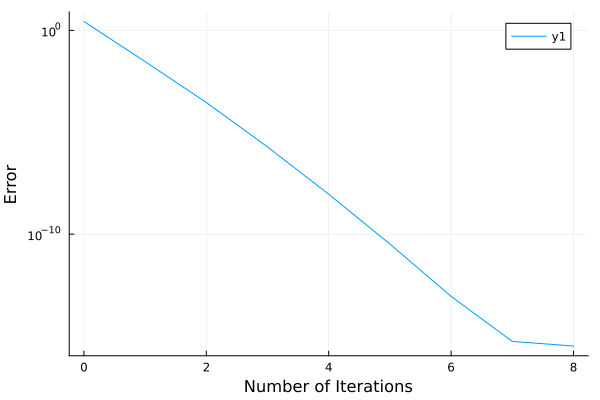

In [79]:
using LinearAlgebra, Plots

u0 = 1.0
a = 0
b = 1.0
f(t, u) = u
N = 30
K = 8 # Number of Iterations
m = 2
err=zeros(K+1)
u, tval= twoleDC(f, a, b, N, u0, Gs, K) # Approximate Solution
U, t = Ref(f, a, b, u0, N) # Reference Solution
for k=1:K+1
    err[k]= norm(U[1, 1:m:end, 2] .- u[1, 1:m:end, k], Inf) .+10^(-16)
end
plot(0:K, err, yaxis=:log, xlabel="Number of Iterations", ylabel="Error")

In [75]:
u0=1.0
K=1
N=6
a=0
b=1.0
f(t, u)=u
u, t=twoleDC(f, a, b, N, u0, Gs, K)

1×7×2 Array{Float64, 3}:
[:, :, 1] =
 1.0  0.0  1.0  0.0  1.0  0.0  0.0

[:, :, 2] =
 1.0  0.0  1.39198  0.0  1.91461  0.0  2.61145